In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

# Arguments 

In [2]:
corr = 0.25

# Load Model

In [3]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "tree_maze"
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
if corr == 0.25:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.2_initseed0_batch512"
elif corr == 0.:
    model_name = "transformer_end_query_embd512_layer3_head4_lr1e-05_drop0_initseed1_batch256"
else:
    raise ValueError(f"Unknown correlation value: {corr}")
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)

eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

epoch=31-val_loss=0.000400.ckpt


In [4]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [5]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_3110024/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [6]:
n_eval_envs = -1 #50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    if n_eval_envs != -1:
        eval_trajs = [eval_trajs[i] for i in traj_indices]
    else:
        n_eval_envs = len(traj_indices)
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    if n_eval_envs != -1:
        random.seed(0)
        eval_trajs = random.sample(eval_trajs, n_eval_envs)
        random.seed()
    else:
        n_eval_envs = len(eval_trajs)


In [7]:
def run_model(traj, model, state_features, seq_length, zero_reward=False):
    hidden_states = [[] for _ in range(model.n_layer)]
    outputs = []
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        if zero_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
            outputs.append(torch.argmax(out).item())
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states, outputs

# Across context decoding
(within-context is not that good)

In [8]:
def get_subtree_location(layer, pos, subtree):
    midpt = 2**(layer-1)
    quarter_pt = midpt//2
    eighth_pt = quarter_pt//2
    if layer == 0:
        return 0
    if subtree == 'half':
        return 1 if pos < midpt else 2
    elif subtree == 'quarter':
        if layer == 1:
            return 0
        bins = np.arange(0, 2**layer, quarter_pt)
        return np.digitize([pos], bins)[0]
    elif subtree == 'eighth':
        if (layer == 1) or (layer == 2):
            return 0
        bins = np.arange(0, 2**layer, eighth_pt)
        return np.digitize([pos], bins)[0]

    

In [9]:
train_envs = np.arange(1, int(n_eval_envs*0.9))
test_envs = np.arange(int(n_eval_envs*0.9), n_eval_envs)

def make_train_test_matrices():
    X = [[] for _ in range(model.n_layer)]
    Ys_dict = {
        "dist_from_goal": [],
        "layer": [],
        "node_identity": [],
        "maze_half": [],
        "maze_quarter": [],
        "maze_eighth": [],
        'is_goal': [],
        'same_half_as_goal': [],
        'same_quarter_as_goal': [],
        'opt_action': [],
        'state_feature': [],
        'action': [],
    }
    for i_eval in range(n_eval_envs):
        onehot_env = np.zeros(n_eval_envs)
        onehot_env[i_eval] = 1
        traj = eval_trajs[i_eval]
        seen_states = np.vstack((traj['context_states'][:1], traj['context_next_states']))
        seen_states = np.unique(seen_states, axis=0) 

        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > 800):
            continue

        env_config = {
            'max_layers': 7,
            'horizon': 1600,
            'branching_prob': 1.0,
            'node_encoding_corr': corr,
            'state_dim': state_dim,
            'initialization_seed': np.array(traj['initialization_seed']).item()
        }
        env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
        opt_action_map, dist_from_goal = env.make_opt_action_dict()

        seq_length = 1000
        hidden_states, outputs = run_model(traj, model, seen_states, seq_length)
        goal_node = env.node_map[tuple(env.goal.tolist())]
        goal_layer = goal_node.layer
        goal_pos = goal_node.pos
        for state_idx, state_feature in enumerate(seen_states):
            state_feature_tuple = tuple(state_feature.tolist())
            d = dist_from_goal[state_feature_tuple]
            layer = env.node_map[state_feature_tuple].layer
            pos = env.node_map[state_feature_tuple].pos
            node_identity = 2**layer + pos
            maze_half = get_subtree_location(layer, pos, 'half')
            maze_quarter = get_subtree_location(layer, pos, 'quarter')
            maze_eighth = get_subtree_location(layer, pos, 'eighth')
            action = outputs[state_idx]
            opt_action = np.zeros(4)
            opt_action[opt_action_map[state_feature_tuple]] = 1
            
            Ys_dict["dist_from_goal"].append(d)
            Ys_dict["layer"].append(layer)
            Ys_dict["node_identity"].append(node_identity)
            Ys_dict["maze_half"].append(maze_half)
            Ys_dict["maze_quarter"].append(maze_quarter)
            Ys_dict["maze_eighth"].append(maze_eighth)
            Ys_dict["is_goal"].append(state_feature_tuple == tuple(env.goal.tolist()))
            Ys_dict["same_half_as_goal"].append(maze_half == get_subtree_location(goal_layer, goal_pos, 'half'))
            Ys_dict["same_quarter_as_goal"].append(maze_quarter == get_subtree_location(goal_layer, goal_pos, 'quarter'))
            Ys_dict["opt_action"].append(opt_action_map[state_feature_tuple])
            Ys_dict["state_feature"].append(state_feature)
            Ys_dict["action"].append(action)
            for layer in range(model.n_layer):
                hidden_state = hidden_states[layer][state_idx][0, -1].to('cpu').numpy()
                hidden_state = np.concatenate([hidden_state, onehot_env])
                X[layer].append(hidden_state)
        torch.cuda.empty_cache()
    test_size = 0.1
    test_start_idx = int(len(X[0])*(1-test_size))
    all_indices = np.arange(len(X[0]))
    np.random.shuffle(all_indices)
    train_indices = all_indices[:test_start_idx]
    test_indices = all_indices[test_start_idx:]

    X_train = [[] for _ in range(model.n_layer)]
    X_test = [[] for _ in range(model.n_layer)]
    Ys_dict_train_test = {key: {'Y_train': [], 'Y_test': []} for key in Ys_dict}
    # Use same indices for all layers to keep corresponding samples together
    for layer, layer_data in enumerate(X):
        X_train[layer] = [layer_data[i] for i in train_indices]
        X_test[layer] = [layer_data[i] for i in test_indices]
    for key in Ys_dict:
        Ys_dict_train_test[key]['Y_train'] = [Ys_dict[key][i] for i in train_indices]
        Ys_dict_train_test[key]['Y_test'] = [Ys_dict[key][i] for i in test_indices]
    return X_train, X_test, Ys_dict_train_test

In [10]:
import warnings

from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

def fit_and_evaluate_regression(X_train, Y_train, X_test, Y_test, print_scores=True):
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import Ridge
    
    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    alphas = np.logspace(0, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, alpha):
        # Train on this fold
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        # Get validation score
        val_score = pipeline.score(X[val_idx], y[val_idx])
        return val_score

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)):
        # Parallel CV for each alpha
        cv_scores = {alpha: [] for alpha in alphas}
        for alpha in alphas:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, alpha
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[alpha] = np.mean(scores)
        
        # Find best alpha
        best_alpha = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best alpha
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        train_score = pipeline.score(X_train_np[layer], Y_train_np)
        test_score = pipeline.score(X_test_np[layer], Y_test_np)
        
        pipelines.append(pipeline)
        test_scores.append(test_score)
        
        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best alpha: {best_alpha:.3f}")
            print(f"Train R2: {train_score:.3f}")
            print(f"Test R2: {test_score:.3f}")
            print()

            y_pred = pipeline.predict(X_test_np[layer])
            plt.figure(figsize=(3, 3))
            plt.scatter(Y_test_np, y_pred, alpha=0.5)
            plt.plot([Y_test_np.min(), Y_test_np.max()], [Y_test_np.min(), Y_test_np.max()], 'r--')
            plt.xlabel('True Values')
            plt.ylabel('Predictions')
            plt.title(f'Layer {layer}: True vs Predicted Values')
            plt.tight_layout()
            plt.show()
            
    return pipelines, test_scores

def fit_and_evaluate_classification(X_train, Y_train, X_test, Y_test, print_scores=True):
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    Cs = np.logspace(-4, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, C):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        y_val_pred = pipeline.predict(X[val_idx])
        # Use balanced accuracy score instead of regular accuracy
        return balanced_accuracy_score(y[val_idx], y_val_pred)

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)):
        # Parallel CV for each C value
        cv_scores = {C: [] for C in Cs}
        for C in Cs:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, C
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[C] = np.mean(scores)
        
        # Find best C
        best_C = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best C
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=best_C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        y_train_pred = pipeline.predict(X_train_np[layer])
        y_test_pred = pipeline.predict(X_test_np[layer])
        
        # Use balanced metrics
        train_accuracy = balanced_accuracy_score(Y_train_np, y_train_pred)
        test_accuracy = balanced_accuracy_score(Y_test_np, y_test_pred)
        train_f1 = f1_score(Y_train_np, y_train_pred, average='weighted')
        test_f1 = f1_score(Y_test_np, y_test_pred, average='weighted')

        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best C: {best_C:.3f}")
            print(f"Train Balanced Accuracy: {train_accuracy:.3f}")
            print(f"Test Balanced Accuracy: {test_accuracy:.3f}")
            print(f"Train Weighted F1: {train_f1:.3f}")
            print(f"Test Weighted F1: {test_f1:.3f}")
            # Add class distribution information
            print("Class distribution:")
            for cls in np.unique(Y_train_np):
                print(f"Class {cls}: {np.sum(Y_train_np == cls)} samples")
            print()

            # Add confusion matrix visualization
            y_test_pred = pipeline.predict(X_test_np[layer])
            cm = confusion_matrix(Y_test_np, y_test_pred)
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Layer {layer}: Confusion Matrix')
            plt.tight_layout()
            plt.show()

    return pipelines, test_scores

In [11]:
X_train, X_test, Ys_dict = make_train_test_matrices()

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Layer 0:
Best C: 0.000
Train Balanced Accuracy: 0.810
Test Balanced Accuracy: 0.791
Train Weighted F1: 0.793
Test Weighted F1: 0.788
Class distribution:
Class False: 5705 samples
Class True: 337 samples



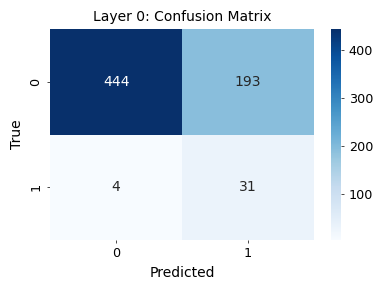

Layer 1:
Best C: 0.001
Train Balanced Accuracy: 0.951
Test Balanced Accuracy: 0.920
Train Weighted F1: 0.937
Test Weighted F1: 0.920
Class distribution:
Class False: 5705 samples
Class True: 337 samples



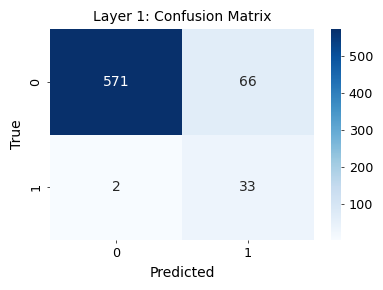

Layer 2:
Best C: 0.000
Train Balanced Accuracy: 0.983
Test Balanced Accuracy: 0.987
Train Weighted F1: 0.982
Test Weighted F1: 0.977
Class distribution:
Class False: 5705 samples
Class True: 337 samples



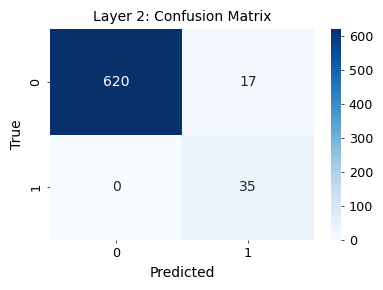

In [12]:
_Y_train = [a in [1, 2] for a in Ys_dict['opt_action']["Y_train"]]
_Y_test = [a in [1, 2] for a in Ys_dict['opt_action']["Y_test"]]
pipeline, test_score = fit_and_evaluate_classification(
    X_train, _Y_train, X_test, _Y_test)

In [24]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["same_quarter_as_goal"]["Y_train"], X_test, Ys_dict["same_quarter_as_goal"]["Y_test"])

Layer 0:
Best C: 0.001
Train Balanced Accuracy: 0.633
Test Balanced Accuracy: 0.623
Train Weighted F1: 0.643
Test Weighted F1: 0.643
Class distribution:
Class False: 4454 samples
Class True: 1588 samples

Layer 1:
Best C: 0.046
Train Balanced Accuracy: 0.713
Test Balanced Accuracy: 0.622
Train Weighted F1: 0.732
Test Weighted F1: 0.667
Class distribution:
Class False: 4454 samples
Class True: 1588 samples

Layer 2:
Best C: 0.046
Train Balanced Accuracy: 0.740
Test Balanced Accuracy: 0.675
Train Weighted F1: 0.754
Test Weighted F1: 0.712
Class distribution:
Class False: 4454 samples
Class True: 1588 samples



In [25]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train,
    [y <= 3 for y in Ys_dict["dist_from_goal"]["Y_train"]],
    X_test,
    [y <= 3 for y in Ys_dict["dist_from_goal"]["Y_test"]]
    )

/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer 0:
Best C: 0.001
Train Balanced Accuracy: 0.775
Test Balanced Accuracy: 0.720
Train Weighted F1: 0.868
Test Weighted F1: 0.854
Class distribution:
Class False: 5718 samples
Class True: 324 samples

Layer 1:
Best C: 0.006
Train Balanced Accuracy: 0.899
Test Balanced Accuracy: 0.864
Train Weighted F1: 0.936
Test Weighted F1: 0.926
Class distribution:
Class False: 5718 samples
Class True: 324 samples

Layer 2:
Best C: 0.006
Train Balanced Accuracy: 0.918
Test Balanced Accuracy: 0.901
Train Weighted F1: 0.949
Test Weighted F1: 0.938
Class distribution:
Class False: 5718 samples
Class True: 324 samples



In [12]:
pipeline, test_score = fit_and_evaluate_regression(X_train, Ys_dict["dist_from_goal"]["Y_train"], X_test, Ys_dict["dist_from_goal"]["Y_test"])

Layer 0:
Best alpha: 464.159
Train R2: 0.313
Test R2: 0.283

Layer 1:
Best alpha: 166.810
Train R2: 0.435
Test R2: 0.383

Layer 2:
Best alpha: 166.810
Train R2: 0.469
Test R2: 0.366



Layer 0:
Best C: 0.000
Train Balanced Accuracy: 0.785
Test Balanced Accuracy: 0.684
Train Weighted F1: 0.762
Test Weighted F1: 0.751
Class distribution:
Class 0: 5629 samples
Class 1: 127 samples
Class 2: 229 samples
Class 3: 57 samples



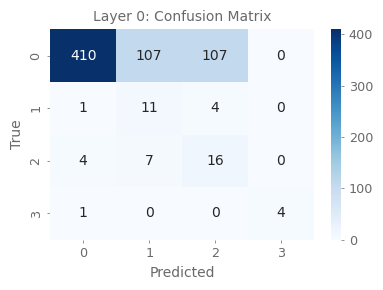

Layer 1:
Best C: 0.001
Train Balanced Accuracy: 0.922
Test Balanced Accuracy: 0.821
Train Weighted F1: 0.930
Test Weighted F1: 0.913
Class distribution:
Class 0: 5629 samples
Class 1: 127 samples
Class 2: 229 samples
Class 3: 57 samples



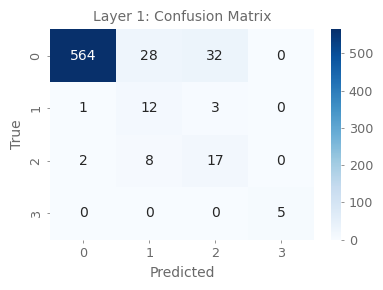

Layer 2:
Best C: 0.001
Train Balanced Accuracy: 0.995
Test Balanced Accuracy: 0.933
Train Weighted F1: 0.992
Test Weighted F1: 0.975
Class distribution:
Class 0: 5629 samples
Class 1: 127 samples
Class 2: 229 samples
Class 3: 57 samples



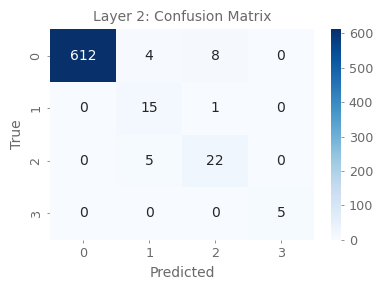

In [33]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["action"]["Y_train"], X_test, Ys_dict["action"]["Y_test"])

In [26]:
_Y_train = [a in [1, 2] for a in Ys_dict['opt_action']["Y_train"]]
_Y_test = [a in [1, 2] for a in Ys_dict['opt_action']["Y_test"]]
pipeline, test_score = fit_and_evaluate_classification(
    X_train, _Y_train, X_test, _Y_test)

Layer 0:
Best C: 0.000
Train Balanced Accuracy: 0.817
Test Balanced Accuracy: 0.761
Train Weighted F1: 0.797
Test Weighted F1: 0.783
Class distribution:
Class False: 5710 samples
Class True: 332 samples

Layer 1:
Best C: 0.001
Train Balanced Accuracy: 0.951
Test Balanced Accuracy: 0.920
Train Weighted F1: 0.937
Test Weighted F1: 0.914
Class distribution:
Class False: 5710 samples
Class True: 332 samples

Layer 2:
Best C: 0.000
Train Balanced Accuracy: 0.983
Test Balanced Accuracy: 0.983
Train Weighted F1: 0.983
Test Weighted F1: 0.971
Class distribution:
Class False: 5710 samples
Class True: 332 samples



In [19]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train, Ys_dict["same_quarter_as_goal"]["Y_train"], X_test, Ys_dict["same_quarter_as_goal"]["Y_test"])

Layer 0:
Best C: 0.001
Train Balanced Accuracy: 0.618
Test Balanced Accuracy: 0.606
Train Weighted F1: 0.636
Test Weighted F1: 0.628
Class distribution:
Class False: 5088 samples
Class True: 1768 samples

Layer 1:
Best C: 0.046
Train Balanced Accuracy: 0.705
Test Balanced Accuracy: 0.645
Train Weighted F1: 0.729
Test Weighted F1: 0.653
Class distribution:
Class False: 5088 samples
Class True: 1768 samples

Layer 2:
Best C: 0.046
Train Balanced Accuracy: 0.730
Test Balanced Accuracy: 0.645
Train Weighted F1: 0.748
Test Weighted F1: 0.677
Class distribution:
Class False: 5088 samples
Class True: 1768 samples



In [13]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["layer"]["Y_train"], X_test, Ys_dict["layer"]["Y_test"])

/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Layer 0:
Best C: 0.006
Train Balanced Accuracy: 0.551
Test Balanced Accuracy: 0.419
Train Weighted F1: 0.594
Test Weighted F1: 0.572
Class distribution:
Class 0: 63 samples
Class 1: 126 samples
Class 2: 250 samples
Class 3: 484 samples
Class 4: 925 samples
Class 5: 1745 samples
Class 6: 3263 samples



/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Layer 1:
Best C: 0.000
Train Balanced Accuracy: 0.653
Test Balanced Accuracy: 0.606
Train Weighted F1: 0.735
Test Weighted F1: 0.722
Class distribution:
Class 0: 63 samples
Class 1: 126 samples
Class 2: 250 samples
Class 3: 484 samples
Class 4: 925 samples
Class 5: 1745 samples
Class 6: 3263 samples



In [29]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["node_identity"]["Y_train"], X_test, Ys_dict["node_identity"]["Y_test"])

Layer 0:
Best C: 0.001
Train Accuracy: 0.068
Test Accuracy: 0.024
Train F1: 0.058
Test F1: 0.022

Layer 1:
Best C: 0.046
Train Accuracy: 0.267
Test Accuracy: 0.047
Train F1: 0.260
Test F1: 0.039

Layer 2:
Best C: 0.359
Train Accuracy: 0.590
Test Accuracy: 0.051
Train F1: 0.582
Test F1: 0.041



Layer 0:
Best C: 0.046
Train Balanced Accuracy: 0.754
Test Balanced Accuracy: 0.590
Train Weighted F1: 0.634
Test Weighted F1: 0.514
Class distribution:
Class 0: 54 samples
Class 1: 2983 samples
Class 2: 3005 samples



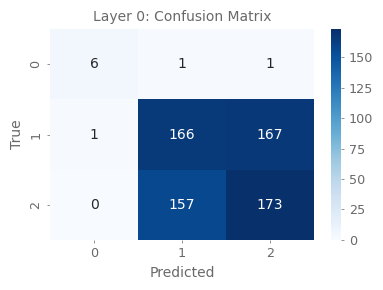

Layer 1:
Best C: 0.046
Train Balanced Accuracy: 0.777
Test Balanced Accuracy: 0.665
Train Weighted F1: 0.668
Test Weighted F1: 0.564
Class distribution:
Class 0: 54 samples
Class 1: 2983 samples
Class 2: 3005 samples



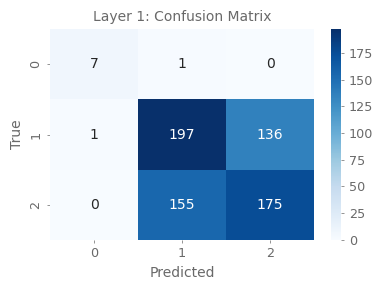

Layer 2:
Best C: 0.359
Train Balanced Accuracy: 0.790
Test Balanced Accuracy: 0.669
Train Weighted F1: 0.688
Test Weighted F1: 0.569
Class distribution:
Class 0: 54 samples
Class 1: 2983 samples
Class 2: 3005 samples



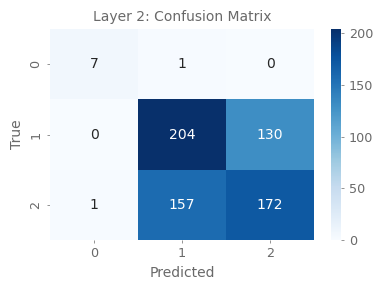

In [29]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_half"]["Y_train"], X_test, Ys_dict["maze_half"]["Y_test"])

In [31]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_quarter"]["Y_train"], X_test, Ys_dict["maze_quarter"]["Y_test"])

Layer 0:
Best C: 2.783
Train Accuracy: 0.460
Test Accuracy: 0.240
Train F1: 0.502
Test F1: 0.267

Layer 1:
Best C: 2.783
Train Accuracy: 0.508
Test Accuracy: 0.264
Train F1: 0.595
Test F1: 0.323

Layer 2:
Best C: 0.359
Train Accuracy: 0.508
Test Accuracy: 0.264
Train F1: 0.593
Test F1: 0.331



In [32]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_eighth"]["Y_train"], X_test, Ys_dict["maze_eighth"]["Y_test"])

Layer 0:
Best C: 0.001
Train Accuracy: 0.202
Test Accuracy: 0.116
Train F1: 0.201
Test F1: 0.121

Layer 1:
Best C: 0.006
Train Accuracy: 0.292
Test Accuracy: 0.137
Train F1: 0.298
Test F1: 0.142

Layer 2:
Best C: 0.001
Train Accuracy: 0.247
Test Accuracy: 0.133
Train F1: 0.257
Test F1: 0.151



In [33]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["action"]["Y_train"], X_test, Ys_dict["action"]["Y_test"])

Layer 0:
Best C: 0.006
Train Accuracy: 0.958
Test Accuracy: 0.946
Train F1: 0.689
Test F1: 0.637

Layer 1:
Best C: 0.001
Train Accuracy: 0.967
Test Accuracy: 0.960
Train F1: 0.753
Test F1: 0.751

Layer 2:
Best C: 0.006
Train Accuracy: 0.998
Test Accuracy: 0.982
Train F1: 0.981
Test F1: 0.868

